In [35]:
import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import yfinance as yf
from scipy.stats import norm
from datetime import datetime

In [36]:
# Define the stock symbol
symbol = "AAPL"
expiry = ql.Date(8, 12, 2023)

# Fetch option chain data from Yahoo Finance
option_chain = yf.Ticker(symbol).options
# Fetch historical stock data from Yahoo Finance
stock_data = yf.download(symbol, start="2022-01-01", end="2023-01-01")
S0 = stock_data['Close'].iloc[-1]  # Current stock price

[*********************100%***********************]  1 of 1 completed


In [37]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,179.273590,104487900
2022-01-04,182.630005,182.940002,179.119995,179.699997,176.998352,99310400
2022-01-05,179.610001,180.169998,174.639999,174.919998,172.290222,94537600
2022-01-06,172.699997,175.300003,171.639999,172.000000,169.414108,96904000
2022-01-07,172.889999,174.139999,171.029999,172.169998,169.581528,86709100
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.631348,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,128.818420,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,124.865593,85438400


In [38]:
# Display the call option data
call_data = yf.Ticker(symbol).option_chain(option_chain[0]).calls
print(call_data.head())

        contractSymbol             lastTradeDate  strike  lastPrice  bid  ask  \
0  AAPL240913C00100000 2024-09-10 13:48:09+00:00   100.0     117.10  0.0  0.0   
1  AAPL240913C00105000 2024-09-10 13:48:09+00:00   105.0     112.10  0.0  0.0   
2  AAPL240913C00110000 2024-09-06 19:05:11+00:00   110.0     111.00  0.0  0.0   
3  AAPL240913C00115000 2024-09-11 18:38:13+00:00   115.0     106.50  0.0  0.0   
4  AAPL240913C00120000 2024-09-10 16:08:42+00:00   120.0      98.75  0.0  0.0   

   change  percentChange  volume  openInterest  impliedVolatility  inTheMoney  \
0     0.0            0.0       1             0            0.00001        True   
1     0.0            0.0       1             0            0.00001        True   
2     0.0            0.0      14             0            0.00001        True   
3     0.0            0.0       1             0            0.00001        True   
4     0.0            0.0       2             0            0.00001        True   

  contractSize currency  


In [39]:
# Retrieve the strike price from the call option data
strike_price = call_data.strike.iat[0]  # Assuming you want the strike price of the first call option
closing_prices=call_data.lastPrice

def calculate_volatility(returns):
    return np.std(returns, ddof=1) * np.sqrt(252)
returns=np.diff(np.log(closing_prices))
historical_volatility = calculate_volatility(returns)
time_duration = len(closing_prices) / 252

In [40]:
def call_payoff(x):
    return np.maximum(x - strike_price, 0)

def put_payoff(x):
    return np.maximum(strike_price - x, 0)

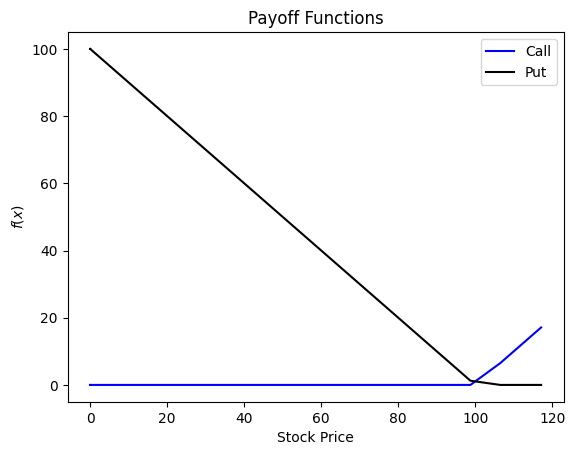

In [41]:
# Plot payoff functions
x_values = closing_prices
plt.plot(x_values, call_payoff(x_values), label='Call', color='blue')
plt.plot(x_values, put_payoff(x_values), label='Put', color='black')
plt.legend()
plt.title("Payoff Functions")
plt.xlabel("Stock Price")
plt.ylabel("$f(x)$")
plt.show()

In [42]:
def BSM_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T ) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [43]:
# Option pricing parameters
r = 0.05  # Risk-free rate
T = 0.5  # Time to maturity (in years)
#T = call_data['DaysDifference']  # Time to maturity (in years)
sigma = historical_volatility # Volatility

In [44]:
# Calculate call option price using Black-Scholes-Merton
call_price_result = BSM_call_price(S0, strike_price,  T, r, sigma)
print(f"Black-Scholes-Merton Call Option Price: {call_price_result}")

Black-Scholes-Merton Call Option Price: 123.40808261936331


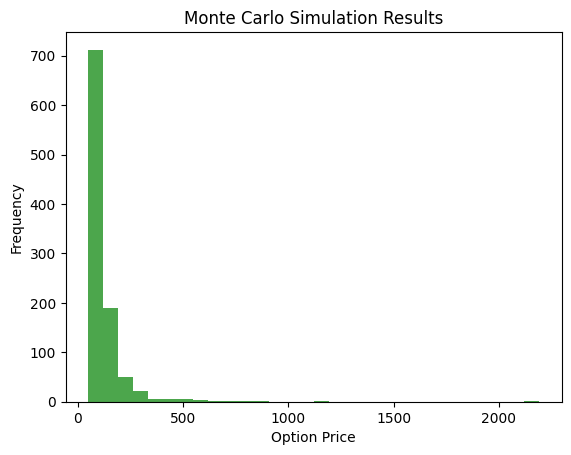

In [45]:
# Monte Carlo simulation
def monte_carlo_price(x, t, T, r, sigma, M, payoff_function):
    spot_price = x
    dt = (T - t) / M
    random_numbers = np.random.randn(M // 2)
    stock_prices = spot_price * np.exp((r - 0.5 * sigma**2) * (T - t) + sigma * np.sqrt(T - t) * random_numbers)

    option_prices = [payoff_function(price) for price in stock_prices]
    return np.mean(option_prices) * np.exp(-r * (T - t))

# Perform Monte Carlo simulation
monte_carlo_results = [monte_carlo_price(S0, 0, T, r, sigma, 100000, call_payoff) for _ in range(1000)]

In [ ]:
# Plot histogram of Monte Carlo results
plt.hist(monte_carlo_results, bins=30, color='green', alpha=0.7)
plt.title('Monte Carlo Simulation Results')
plt.xlabel('Option Price')
plt.ylabel('Frequency')
plt.show()